In [2]:
import os
import sys
# !pip install torch torchsde numpy seaborn matplotlib

sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torchsde
from fractional_neural_sde.fractional_noise import SparseGPNoise
from fractional_neural_sde.latent_sde import LatentSDE
from fractional_neural_sde.utils import LinearScheduler, manual_seed, plot_setting
from torch import distributions, optim


plot_setting(font_size=20)

  Using cached torch-2.1.0-cp311-none-macosx_11_0_arm64.whl.metadata (24 kB)
  Using cached torchsde-0.2.6-py3-none-any.whl.metadata (5.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.2 MB/s eta 0:00:0000:01
  Using cached seaborn-0.13.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached fsspec-2023.10.0-py3-none-any.whl.metadata (6.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.4/165.4 kB 2.8 MB/s eta 0:00:0000:01
  Using cached trampoline-0.1.2-py3-none-any.whl (5.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.6/153.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 7.7 MB/s eta 0:00:0000:01
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Using cached torch-2.1.0-cp311-none-macosx_11_0_arm64.whl (59.6 MB)
Using cached torchsde-0.

In [3]:
class TrueNoise(SparseGPNoise):
    def compute_hurst(self, t):
        t = t.view(-1, 1)
        return torch.ones(1, 1) * torch.sigmoid((1.0 - t) * 7.0) * 0.5 + 0.3


def get_data():

    t0, t1 = 0.0, 2.0
    batch_size = 200

    x0 = 1.0
    alpha = 0.5
    beta = 0.5
    true_wn = TrueNoise(t0=t0, t1=t1, dt=1e-2, num_steps=500, num_inducings=50)

    true_wn.precompute(batch_size=batch_size)

    ts, B_h, _ = true_wn.sample_alternative(batch_size)

    ht = torch.stack(
        [true_wn.compute_hurst(t) for t in ts], dim=0
    )  # t_size, 1, state_size

    # the exact solution
    X_t = x0 * torch.exp(
        beta * B_h
        + alpha * ts.reshape(-1, 1, 1)
        - 0.5 * beta**2 * ts.reshape(-1, 1, 1) ** (2 * ht)
    )
    X_t = X_t.squeeze().transpose(0, 1)

    # shift time a bit
    shift = 0.1
    start = ts[0].reshape((1,))
    end = ts[-1].reshape((1,)) + shift
    ts = ts + shift
    ts_ext = torch.cat([start, ts, end], dim=0)

    return ts, ts_ext, X_t[1], ht

In [4]:
def plot(
    sample_fn, ts, ys, ts_vis, batch_size, sdeint_fn, eps, bm, method, dt, prior=True
):

    palette = sns.color_palette("Blues_r")

    fill_color = palette[2]
    mean_color = palette[0]

    alphas = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
    percentiles = [0.999, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

    with torch.no_grad():
        zs = sample_fn(
            ts=ts_vis,
            batch_size=batch_size,
            sdeint_fn=sdeint_fn,
            method=method,
            dt=dt,
            bm=bm,
            eps=eps,
        )
        zs = zs.squeeze()
        ts_vis_, zs_ = ts_vis.cpu().numpy(), zs.cpu().numpy()
        zs_ = np.sort(zs_, axis=1)

        plt.subplots(figsize=(8, 4), frameon=False)

        for alpha, percentile in zip(alphas, percentiles):
            idx = int((1 - percentile) / 2.0 * batch_size)
            zs_bot_, zs_top_ = zs_[:, idx], zs_[:, -idx]
            plt.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color)

        if not prior:
            # plot mean
            plt.plot(
                ts_vis_,
                zs_.mean(axis=1),
                color=mean_color,
                linestyle="--",
                linewidth=2.5,
            )

        # plot data
        if ys.ndim == 2:
            plt.scatter(ts, ys[:, 0], marker="x", zorder=3, color="k", s=50)
        else:
            plt.scatter(ts, ys, marker="x", zorder=3, color="k", s=50)

        plt.xlabel("$t$")
        plt.ylabel("$X_t$")
        plt.tight_layout()


def plot_posterior(
    sample_fn, ts, ys, ts_vis, batch_size, sdeint_fn, eps, bm, method, dt
):
    plot(
        sample_fn,
        ts,
        ys,
        ts_vis,
        batch_size,
        sdeint_fn,
        eps,
        bm,
        method,
        dt,
        prior=False,
    )


def plot_h(hurst_fn, ts_vis, ts, true_ht, shift=0.05):
    """Plot Hurst function"""
    plt.figure(figsize=(5, 4))

    with torch.no_grad():
        ht = hurst_fn(ts_vis)
        ts_vis_, ht_ = ts_vis.cpu().numpy(), ht.cpu().numpy()

        plt.plot(ts_vis_ - shift, ht_, label="ours", alpha=0.8)
        plt.plot(ts - shift, true_ht, label="true", alpha=0.8)
        plt.xlabel(r"$t$")
        plt.ylabel(r"$h(t)$")
        plt.legend()

In [5]:
train_dir = "./dump/"
adjoint = False
device = "cuda"
train_iters = 3000
kl_anneal_iters = 100
likelihood_cls = distributions.Laplace
scale = 0.025
method = "euler"
dt = 5 * 1e-3
batch_size = 1024
seed = 0

In [17]:
manual_seed(seed)

device = torch.device(device if torch.cuda.is_available() else "cpu")
train_dir = os.path.join(train_dir, "synthetic")
ckpt_dir = os.path.join(train_dir, "ckpts")
os.makedirs(ckpt_dir, exist_ok=True)
ts, ts_ext, ys, ht = get_data()

ts_, ys_ = ts, ys
ht = ht.squeeze()

ts, ys = ts.to(device), ys.to(device)[:, None]

In [18]:
plt.figure(figsize=(8, 4))
plt.scatter(ts_, ys_, marker="x", s=50)

In [8]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

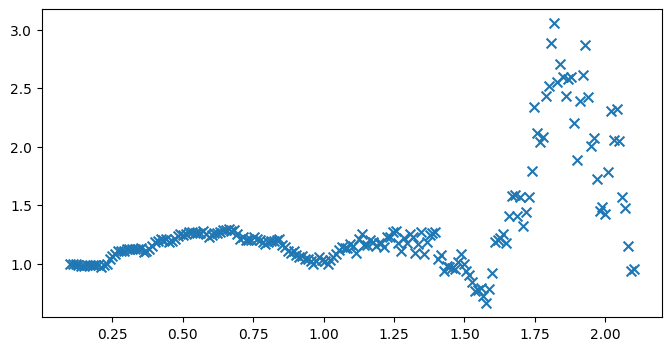

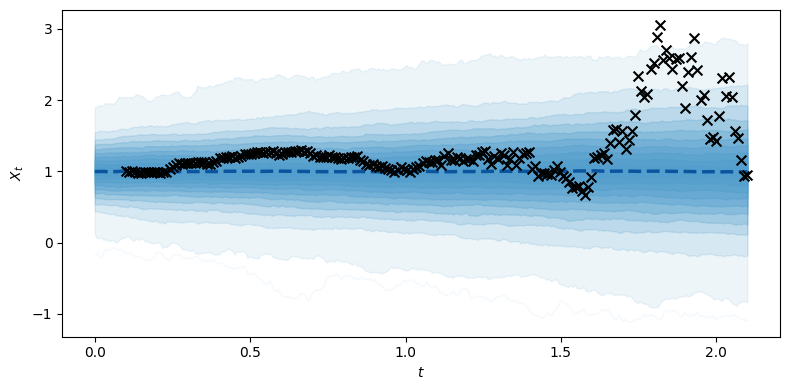

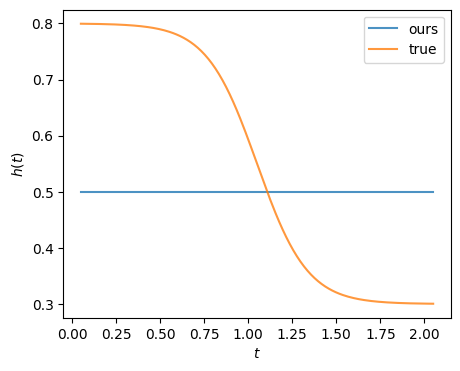

Iter: 0 	logpy: -4116.971 	kl: 56.548 	loss: 4117.537


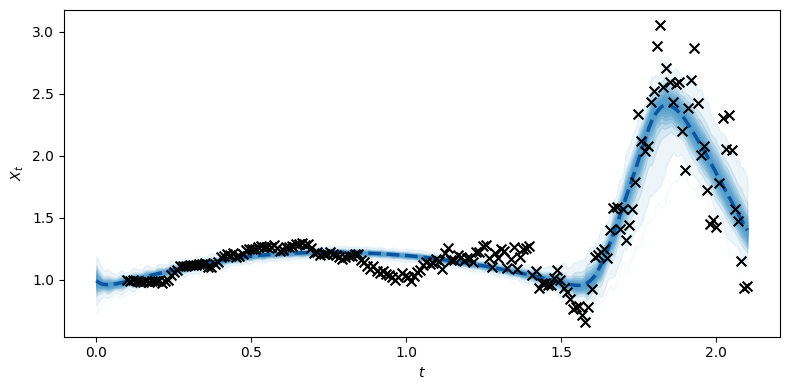

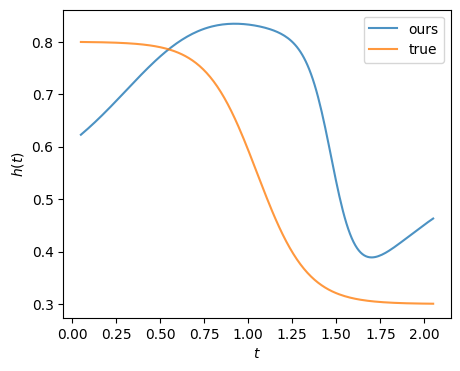

Iter: 500 	logpy: -239.085 	kl: 128.225 	loss: 367.310


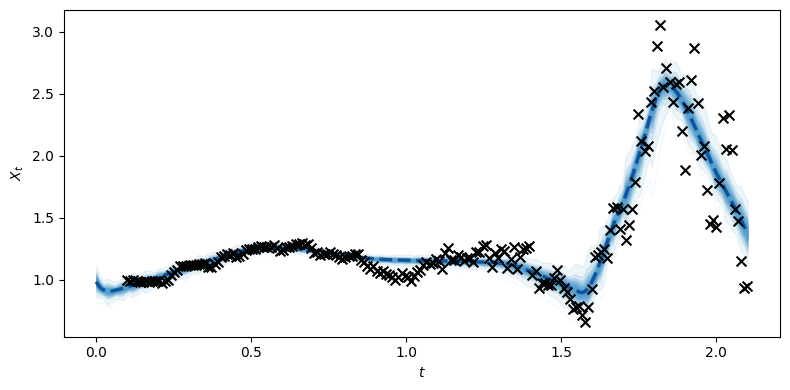

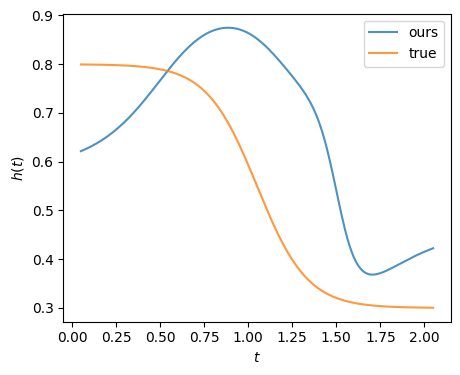

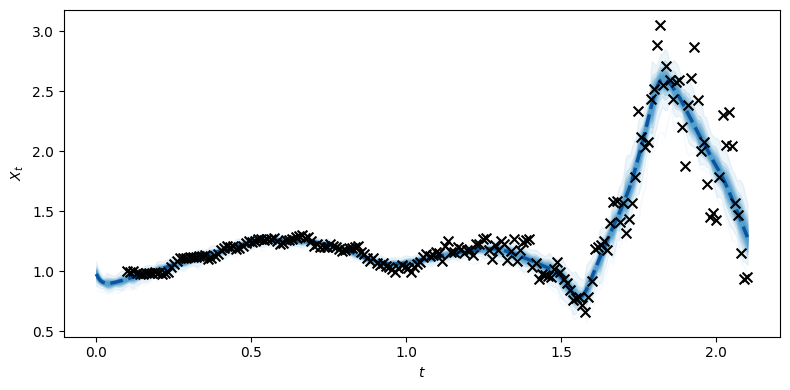

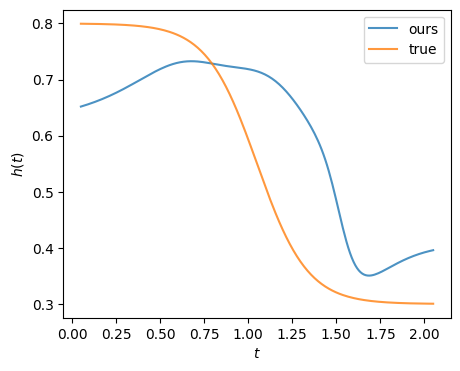

Iter: 1000 	logpy: -75.048 	kl: 153.413 	loss: 228.461


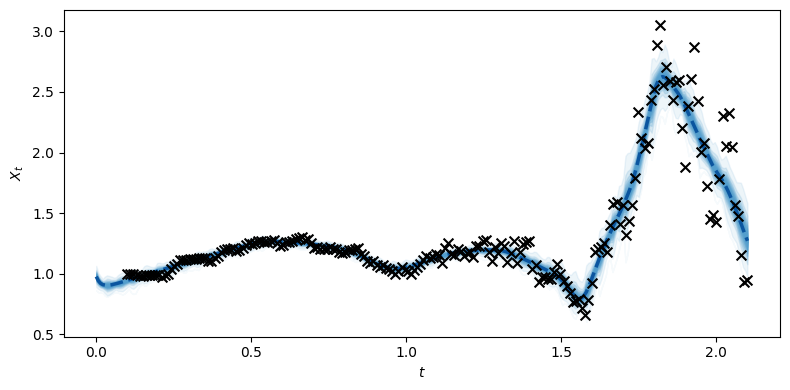

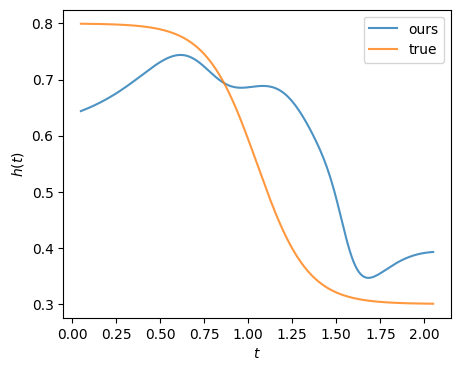

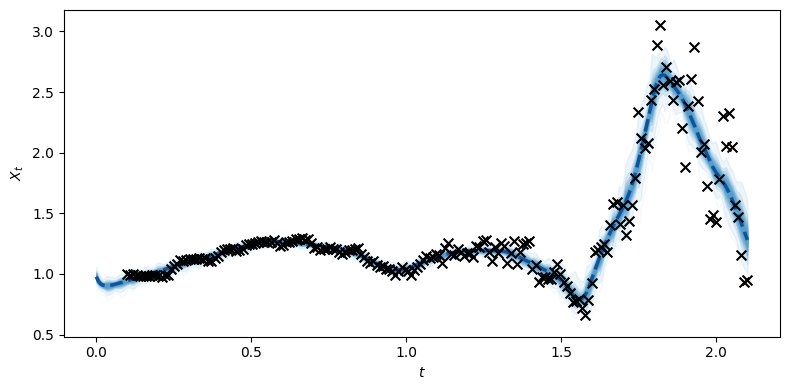

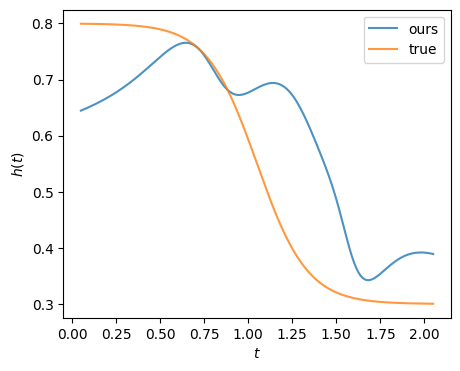

Iter: 1500 	logpy: -53.630 	kl: 157.297 	loss: 210.928


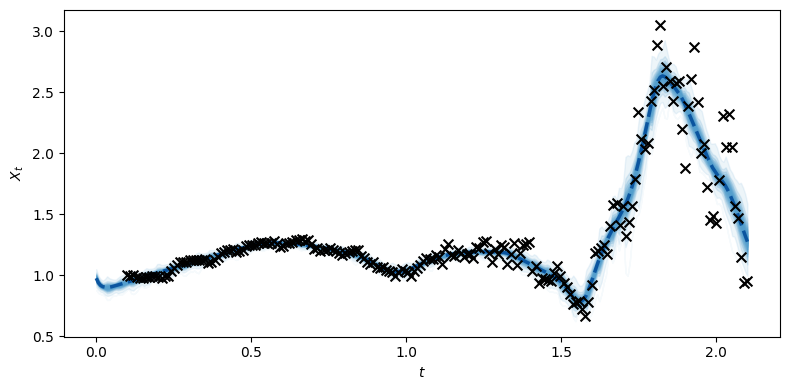

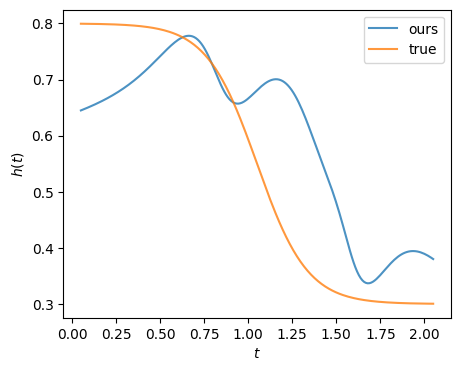

Iter: 2000 	logpy: -45.230 	kl: 158.968 	loss: 204.198


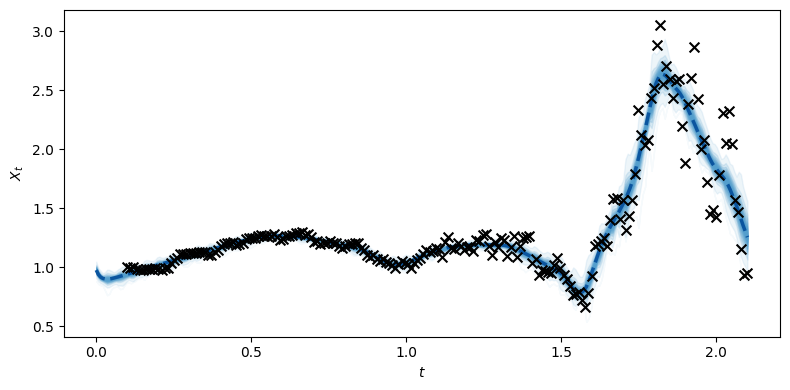

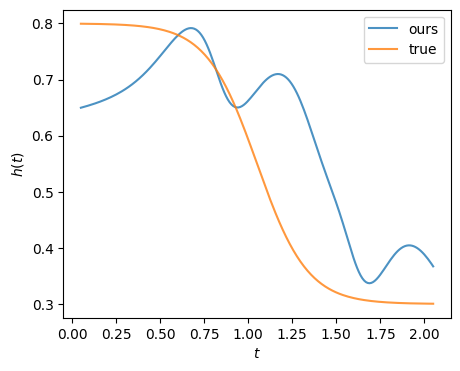

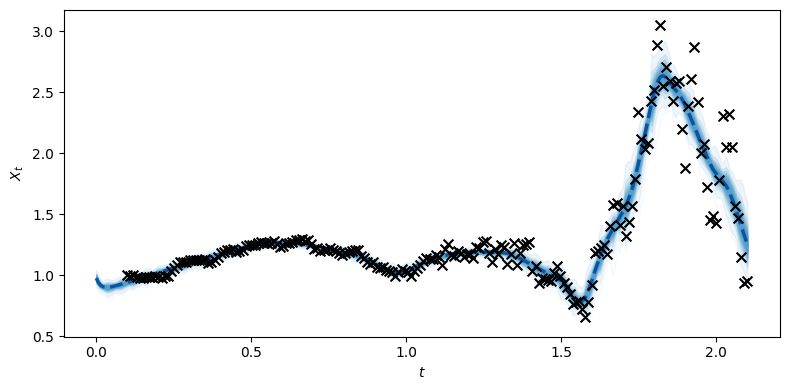

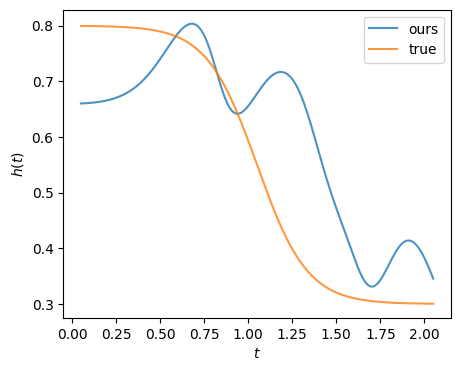

Iter: 2500 	logpy: -37.790 	kl: 159.322 	loss: 197.112


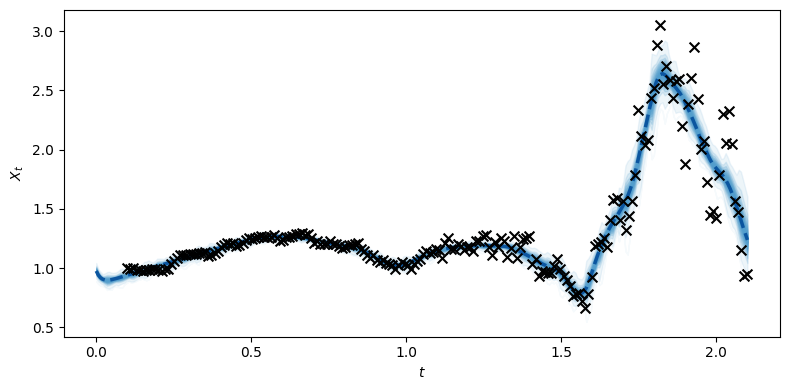

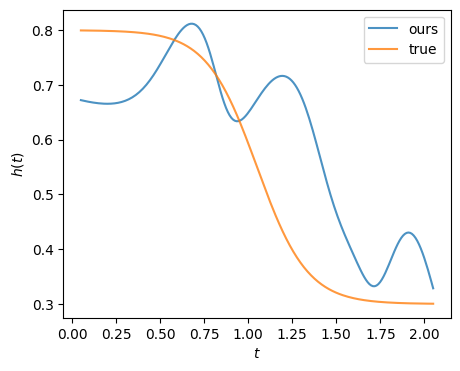

In [10]:
white_noise = SparseGPNoise(
    t0=ts_ext[0], t1=ts_ext[-1], dt=dt, num_steps=200, num_inducings=50
).to(device)

model = LatentSDE(white_noise).to(device)
sdeint_fn = torchsde.sdeint_adjoint if adjoint else torchsde.sdeint
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
kl_scheduler = LinearScheduler(iters=kl_anneal_iters)

# for visualization
vis_batch_size = 1024
ts_vis = torch.linspace(ts_ext[0], ts_ext[-1], 300).to(device)
eps = torch.randn(vis_batch_size, 1).to(device)
bm_vis = torchsde.BrownianInterval(
    t0=ts_ext[0],
    t1=ts_ext[-1],
    size=(vis_batch_size, 1),
    device=device,
    levy_area_approximation="space-time",
)

for i in range(train_iters):
    if i % 300 == 0:
        plot_posterior(
            model.sample_q,
            ts=ts_,
            ys=ys_,
            ts_vis=ts_vis,
            batch_size=vis_batch_size,
            sdeint_fn=sdeint_fn,
            bm=bm_vis,
            eps=eps,
            method=method,
            dt=dt,
        )
        plot_h(model.noise_path.compute_hurst, ts, ts_, ht)
        plt.show()
        plt.close()

    optimizer.zero_grad()
    zs, kl = model(
        ts=ts, batch_size=batch_size, sdeint_fn=sdeint_fn, method=method, dt=dt
    )
    zs = zs.squeeze()
    zs = zs[1:-1]

    likelihood = likelihood_cls(loc=zs, scale=scale)
    logpy = likelihood.log_prob(ys[1:-1]).sum(dim=0).mean(dim=0)

    loss = -logpy + kl * kl_scheduler.val
    loss.backward()

    optimizer.step()
    scheduler.step()
    kl_scheduler.step()
    if i % 500 == 0:
        print(
            f"Iter: {i} \t"
            f"logpy: {logpy.detach().cpu().numpy():.3f} \t"
            f"kl: {kl.cpu().detach().cpu().numpy():.3f} \t"
            f"loss: {loss.cpu().detach().cpu().numpy():.3f}"
        )

In [13]:
plot_posterior(
    model.sample_q,
    ts=ts_,
    ys=ys_,
    ts_vis=ts_vis,
    batch_size=vis_batch_size,
    sdeint_fn=sdeint_fn,
    bm=bm_vis,
    eps=eps,
    method=method,
    dt=dt,
)

In [25]:
(ts_)

tensor([0.1000, 0.1101, 0.1201, 0.1302, 0.1402, 0.1503, 0.1603, 0.1704, 0.1804,
        0.1905, 0.2005, 0.2106, 0.2206, 0.2307, 0.2407, 0.2508, 0.2608, 0.2709,
        0.2809, 0.2910, 0.3010, 0.3111, 0.3211, 0.3312, 0.3412, 0.3513, 0.3613,
        0.3714, 0.3814, 0.3915, 0.4015, 0.4116, 0.4216, 0.4317, 0.4417, 0.4518,
        0.4618, 0.4719, 0.4819, 0.4920, 0.5020, 0.5121, 0.5221, 0.5322, 0.5422,
        0.5523, 0.5623, 0.5724, 0.5824, 0.5925, 0.6025, 0.6126, 0.6226, 0.6327,
        0.6427, 0.6528, 0.6628, 0.6729, 0.6829, 0.6930, 0.7030, 0.7131, 0.7231,
        0.7332, 0.7432, 0.7533, 0.7633, 0.7734, 0.7834, 0.7935, 0.8035, 0.8136,
        0.8236, 0.8337, 0.8437, 0.8538, 0.8638, 0.8739, 0.8839, 0.8940, 0.9040,
        0.9141, 0.9241, 0.9342, 0.9442, 0.9543, 0.9643, 0.9744, 0.9844, 0.9945,
        1.0045, 1.0146, 1.0246, 1.0347, 1.0447, 1.0548, 1.0648, 1.0749, 1.0849,
        1.0950, 1.1050, 1.1151, 1.1251, 1.1352, 1.1452, 1.1553, 1.1653, 1.1754,
        1.1854, 1.1955, 1.2055, 1.2156, 

In [27]:
sdeint_fn

<function torchsde._core.sdeint.sdeint(sde, y0, ts, bm=None, method=None, dt=0.001, adaptive=False, rtol=1e-05, atol=0.0001, dt_min=1e-05, options=None, names=None, logqp=False, extra=False, extra_solver_state=None, **unused_kwargs)>

In [28]:
ts=ts, batch_size=batch_size, sdeint_fn=sdeint_fn, method=method, dt=dt

0.005